# AlphaGear POC

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Basic functions
from rl_glue import RLGlue
from environment import BaseEnvironment
from agent import BaseAgent

# Custom function for the environment and reward function
from environment_alphagear import RiskEnvironmentPOC

# Custom functions for the agent functions
from agent_funcs import *
from collections import deque
from copy import deepcopy
from tqdm import tqdm
import os 
import shutil

C:\Users\david\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Agent

In [2]:
class ExpectedSarsaAgent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"
        
    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer, 
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        self.optimizer = Adam(self.network.layer_sizes, agent_config["optimizer_config"])
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        
        self.last_state = None
        self.last_action = None
        
        self.sum_rewards = 0
        self.episode_steps = 0

    # Work Required: No.
    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action. 
        """
        action_values = self.network.get_action_values(state)
        probs_batch = softmax(action_values, self.tau)
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        return action

    # Work Required: No.
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action

    # weights update using optimize_network, and updating last_state and last_action.
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        self.sum_rewards += reward
        self.episode_steps += 1

        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        action = self.policy(state)
        
        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, False, state)
           
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)
                
                
        # Update the last state and last action.
        self.last_state = state
        self.last_action = action      
        
        return action

    # update of the weights using optimize_network.
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)

        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, True, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)
                    
        
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

## Test

In [ ]:
### Script is a combination of the experiment scripts from 2.3 and 4.2

# Environment parameters
num_states = 25
num_actions = num_states * 5

env_info = {'states':num_states}

environment = RiskEnvironmentPOC

all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes

# Agent parameters

agents = {
    "Expected Sarsa": ExpectedSarsaAgent
}

# should be 32 x states for the hidden variables

agent_info = {
    'network_config': {
        'state_dim': num_states,
        'num_hidden_units': (num_states*8),
        'num_actions': num_actions
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 4,
    'gamma': 0.95,
    'tau': 1
}

# Experiment parameters
num_runs = 10 #100 The number of runs - take average to reduce variance
num_episodes = 200 #200 # The number of episodes in each run - it is a single game played to completion
max_steps_episode = 10000

for algorithm in agents:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run # I think this is just a run identifier
        
        # Agent initialization
        rl_glue = RLGlue(environment, agents[algorithm])
        print("agent initialized")
        rl_glue.rl_init(agent_info, env_info)
        #rl_glue.rl_episode(max_steps_episode)
        print("parameters passed")
        
        reward_sums = []
        #state_visits = np.zeros(num_states)
        
        for episode in range(num_episodes):
            rl_glue.rl_episode(max_steps_episode)
            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            reward_sums.append(rl_glue.rl_return())            
            '''
            if episode < num_episodes - 10:
                # Runs an episode without recording... due to the variance?
                rl_glue.rl_episode(max_steps_episode) 
            else: 
                # Runs an episode while keeping track of visited states ONLY FOR LAST 10 EPISODES
                state, action = rl_glue.rl_start()
                #state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    #state_visits[state] += 1
                
            reward_sums.append(rl_glue.rl_return())
            '''    
        all_reward_sums[algorithm].append(reward_sums)
        #all_state_visits[algorithm].append(state_visits)

# plot results
for algorithm in agents:
    # Plots the AVERAGE sum of rewards across runs for an Episode 
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.ylim(-100,0)
plt.legend()
plt.show()








  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

agent initialized
parameters passed









 10%|████████▎                                                                          | 1/10 [00:53<08:00, 53.40s/it]

agent initialized
parameters passed









 20%|████████████████▌                                                                  | 2/10 [01:45<07:03, 52.97s/it]

agent initialized
parameters passed









 30%|████████████████████████▉                                                          | 3/10 [02:35<06:04, 52.03s/it]

agent initialized
parameters passed









 40%|█████████████████████████████████▏                                                 | 4/10 [03:17<04:55, 49.19s/it]

agent initialized
parameters passed









 50%|█████████████████████████████████████████▌                                         | 5/10 [04:09<04:09, 49.86s/it]

agent initialized
parameters passed









 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:56<03:16, 49.15s/it]

agent initialized
parameters passed









 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:42<02:24, 48.01s/it]

agent initialized
parameters passed


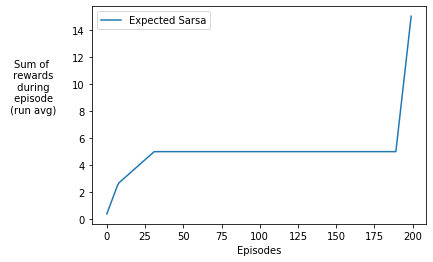

In [21]:
# plot results
for algorithm in agents:
    # Plots the AVERAGE sum of rewards across runs for an Episode 
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)

plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode\n (run avg)",rotation=0, labelpad=40)
plt.legend()
plt.show()

In [22]:
test_1 = np.mean(all_reward_sums[algorithm], axis=0)

### TO DO

- Accomodate new environments each run (rather than just a single one)
    - Move environment initialization into Run loop
- Get rid of the long episode runs 
    - Do it more like Capstone v2
- Plot the average visits on each square (see assignment 2.3)
    - Note: states are actually high dimension - can't keep track of visits on a state
- Annimate the last episode of the last run

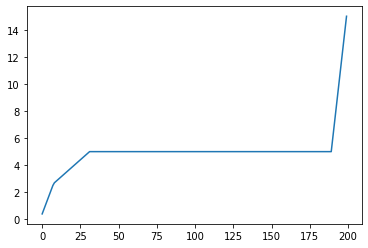